In [1]:
import numpy as np
import pandas as pd
import datahugger
import h5py

In [2]:
dh = datahugger.get("10.17605/OSF.IO/EWS27", "../data")
dh.tree() # Remains to be done: extracting the paths instead of hardcoded (as below):

File already exists: 19_09_2023_22_58_21/LMAHeureuxPorosityDiff.hdf5
File already exists: 19_09_2023_22_58_21/U_at_bottom.h5


21_09_2023_09_29_17/U_at_bottom.h5 : 100%|███████████████████████████| 147k/147k
21_09_2023_09_29_17/LMAHe[...].hdf5: 100%|█████████████████████████| 21.0M/21.0M

data/
├── 19_09_2023_22_58_21/
│   ├── LMAHeureuxPorosityDiff.hdf5
│   └── U_at_bottom.h5
└── 21_09_2023_09_29_17/
    ├── LMAHeureuxPorosityDiff.hdf5
    └── U_at_bottom.h5

2 directories, 4 files
README Data Code


Importing U_at_bottom.h5 using h5py results in an odd file structure so for now using pandas instead.

In [3]:
U_path = "../data/21_09_2023_09_29_17/U_at_bottom.h5"
U_file = pd.read_hdf(U_path)
U_at_bottom_and_times = U_file.to_numpy()
U_at_bottom_and_times.shape

(3001, 2)

In [4]:
Solution_path = '../data/21_09_2023_09_29_17/LMAHeureuxPorosityDiff.hdf5' # Also to be downloaded
Solution = h5py.File(Solution_path, 'r')
data = Solution['data']
data.shape

(3001, 5, 200)

Check the values of U at the bottom:

In [5]:
U_at_bottom_and_times[2995:3000, 1]

array([12.53908529, 12.53908529, 12.53908529, 12.53908529, 12.53908529])

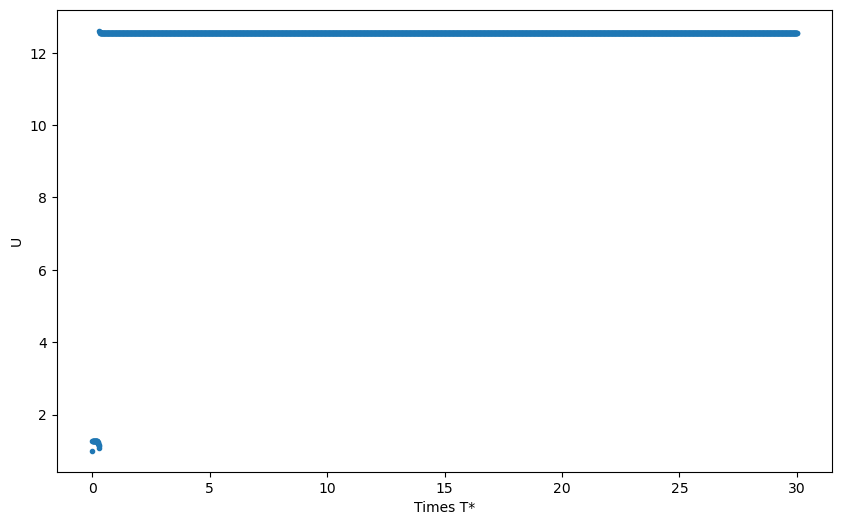

In [6]:
import pylab as pyl
pyl.figure(figsize=(10,6))
pyl.plot(U_at_bottom_and_times[:, 0], U_at_bottom_and_times[:, 1], ".")
pyl.xlabel("Times T*")
pyl.ylabel("U")
pyl.show()

### What is it supposed to be according to Eq. 46.
The formula for K (Eq. 15 in L'Heureux 2018) is used for moderate (0.05, 0.95) values of phi in Fortran and throughout in Python. So it might need changing for phi at the bottom for the calculation of U.

$ K = \beta\frac{\phi^{3}}{(1-\phi)^{2}}F(\phi)$

where

$F(\phi) = 1 - exp\Bigg(-\frac{10(1-\phi)}{\phi}\Bigg)$

In [7]:
def k_normal(phi):
    k = betasV * phi ** 3 / (1 - phi) ** 2
    k = k * (1 - np.exp(-10 * (1 - phi) / phi))
    return k

Keeping the same convention as in Fortran for easy comparing, at the expense of creating redundant variables:

In [9]:
S = float(Solution.attrs['sedimentationrate'])
Vscale = S 
beta = float(Solution.attrs['beta']) # cm/a
P_32 = beta/Vscale
betasV = P_32

In [10]:
phi0 = float(Solution.attrs['Phi0'])
rhow = float(Solution.attrs['rhow'])
rhoa = float(Solution.attrs['rhoa'])
CA0 = float(Solution.attrs['CA0'])
rhoc = float(Solution.attrs['rhoc'])
CC0 = float(Solution.attrs['CC0'])
rhot = float(Solution.attrs['rhot'])
rhos0 = rhoa * CA0 + rhoc * CC0 + rhot * (1 - (CA0 + CC0))
rhos0

2.8630000000000004

In [11]:
phi_bottom = data[3000,4,199]
CA = data[3000,0,199]
CC = data[3000,1,199]
rhos_bottom = rhoa * CA + rhoc * CC + rhot * (1 - (CA + CC))

In [23]:
U_equation = 1 - k_normal(phi0)/S * (1 - phi0) * (rhos0/rhow - 1) + k_normal(phi_bottom)/S * (1 - phi_bottom) * (rhos_bottom/rhow - 1)

Ee. 46 is:

$U = 1 - \frac{K(\phi^{0})}{S}(1-\phi^{0})\Bigg(\frac{\rho_{s}^{0}}{\rho_{w}}-1\Bigg)+\frac{K(\phi)}{S}(1-\phi)\Bigg(\frac{\rho_{s}}{\rho_{w}}-1\Bigg) $

In [24]:
U_equation

110.74179140013992

Whereas U saved from the solution is:

In [32]:
U_at_bottom_and_times[3000, 1]

12.539085291417724

Let's try to track why the latter is different. In marlpde, we have:

`U = presum + rhorat * Phi ** 3 * F /one_minus_Phi`

so let's doodle what it gives at the bottom:

In [26]:
rhorat0 = (rhos0 / rhow - 1) * beta / S
rhorat0

1.7986314760508315

In [27]:
presum = 1 - rhorat0 * phi0 ** 3 * (1 - np.exp(10 - 10 / phi0)) / (1 - phi0)
presum

-3.2265364833646046

In [28]:
rhorat = (rhos_bottom / rhow - 1) * beta / S
F = 1 - np.exp(10 - 10 / phi_bottom)

In [29]:
U_marlpde = presum + rhorat * phi_bottom ** 3 * F /(1 - phi_bottom)
U_marlpde

11.974179140013982

Sadly notebooks do not seem to support inline variable evaluation inside markdown cells, so a clunky summary:

In [39]:
f"U calculated from Eq. 46 = {round(U_equation, 2)}, U exported into hdf5 = {round(U_at_bottom_and_times[3000, 1],2)}, U calculated in marlpde = {round(U_marlpde,2)}"

'U calculated from Eq. 46 = 110.74, U exported into hdf5 = 12.54, U calculated in marlpde = 11.97'

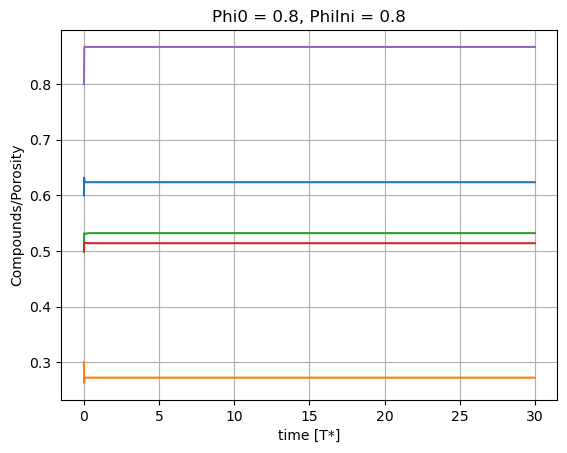

In [40]:
import matplotlib.pyplot as plt
t = np.array(Solution['times'][:])
s = np.array(data[:,:,0])
fig, ax = plt.subplots()
ax.plot(t, s)
ax.set(xlabel='time [T*]', ylabel='Compounds/Porosity',
       title=f"Phi0 = {phi0}, PhiIni = {Solution.attrs['PhiIni']}")
ax.grid()